# CE-40717: Machine Learning

## HW8-Clustering & Reinforcement Learning

[<img src="./images/ML2021S-HW8.jpg" width=1111>](https://quera.ir/assignment/31038/get_pdf_file)

---
---

### Kmeans & GMM:

At this question, we tend to implement Kmeans & GMM algorithms. For this purpose, `DO NOT EMPLOY` ready-for-use python libraries. Use this implementation for solving the following questions. Kmeans should continue till centeroids won't change. Furthermore, GMM also should continue till the difference of two consecutive likelihood logarithm would be less than 0.1. Notice that after executing the Kmeans part, the primitive centroids of GMM should be identical with ultimate Kmeans centroids.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym


from sklearn.datasets import make_classification, make_moons, make_circles
# from sklearn.datasets.samples_generator import make_classification, make_moons, make_circles
from scipy.stats import multivariate_normal
from sklearn import metrics

try:    # SciPy >= 0.19
    from scipy.special import comb, logsumexp
except ImportError:
    from scipy.misc import comb, logsumexp

from jupyterthemes import jtplot

#### Part 1:

Utilize the subsequent cell in order to create the Dataset. Afterwards, try to execute the algorithm with k=2 centroids. At Kmeans, it is recommended to execute the algorithm with several various starting states in order to eventually choose the best respective result.

In [2]:
def forgy(X, row_count, n_clusters):
    return X [np.random.choice(row_count, size=n_clusters, replace=False)]


def macqueen(X, n_clusters):
    return X [:n_clusters]


def maximin(X, n_clusters):
    X_ = np.copy(X)
    initial_centers = np.zeros((n_clusters, X_.shape[1]))
    X_norms = np.linalg.norm(X_, axis=1)
    X_norms_max_i = X_norms.argmax()
    initial_centers[0] = X_[X_norms_max_i]
    X_ = np.delete(X_, X_norms_max_i, axis=0)
    for i in range(1, n_clusters):
        distances = np.zeros((X_.shape[0], i))
        for index, center in enumerate(initial_centers[:i]):
            distances[:, index] = np.linalg.norm(X_-center, axis=1)

        max_min_index = distances.min(axis=1).argmax()

        initial_centers[i] = X_[max_min_index]
        X_ = np.delete(X_, max_min_index, axis=0)

    return initial_centers


def var_part(X, n_clusters):
    X_ = np.append(X, np.zeros(X.shape[0])[:, np.newaxis], axis=1)
    initial_centers = np.zeros((n_clusters, X.shape[1]))

    cluster_i = 1
    while cluster_i != n_clusters:
        within_clusters_sum_squares = np.zeros(cluster_i)
        for j in range(cluster_i):
            cluster_members = X_[X_[:, -1]==j]
            cluster_mean = cluster_members.mean(axis=0)
            within_clusters_sum_squares[j] = np.linalg.norm(cluster_members-cluster_mean, axis=1).sum()

        # Cluster which has greatest SSE
        max_sse_i = within_clusters_sum_squares.argmax()
        X_max_sse_i = X_[:, -1]==max_sse_i
        X_max_sse = X_ [X_max_sse_i]

        variances, means = X_max_sse.var(axis=0), X_max_sse.mean(axis=0)
        max_variance_i = variances.argmax()
        max_variance_mean = means [max_variance_i]

        X_smaller_mean = X_max_sse[:, max_variance_i]<=max_variance_mean
        X_greater_mean = X_max_sse[:, max_variance_i]>max_variance_mean

        initial_centers[max_sse_i] = X_max_sse[X_smaller_mean].mean(axis = 0)[:-1]
        initial_centers[cluster_i] = X_max_sse[X_greater_mean].mean(axis = 0)[:-1]

        X_[(X_max_sse_i) & (X_[:, max_variance_i]<=max_variance_mean), -1] = cluster_i
        X_[(X_max_sse_i) & (X_[:, max_variance_i]>max_variance_mean), -1] = max_sse_i

        cluster_i += 1

    return initial_centers


def scatter1(xl, yl, title):
    jtplot.style(theme="onedork", context="notebook", grid=False)
    plt.close()
    for i, cluster_mean in enumerate(clusters):
        data_cluster_i = data_with_clusters[data_with_clusters[:, -1]==i]
        plt.scatter(data_cluster_i[:, 0], data_cluster_i[:, 1], label=f"Cluster {i}")
        plt.plot(cluster_mean[0], cluster_mean[1], label=f"Centroid {i}", marker='*', markersize=15, markeredgecolor='k', markeredgewidth=1)
        plt.style.use("seaborn")
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title(title)
        plt.legend()


class KMeans:
    def __init__(self, n_clusters=3, tolerance=0.01, max_iter=100, runs=1, init_method="forgy"):
        self.n_clusters = n_clusters
        self.tolerance = tolerance
        self.cluster_means = np.zeros(n_clusters)
        self.max_iter = max_iter
        self.init_method = init_method
        self.runs = runs if init_method=="forgy" else 1


    def __initialize_means(self, X, row_count):
        if self.init_method == "forgy":
            return forgy(X, row_count, self.n_clusters)
        elif self.init_method == "maximin":
            return maximin(X, self.n_clusters)
        elif self.init_method == "macqueen":
            return macqueen(X, self.n_clusters)
        elif self.init_method == "var_part":
            return var_part(X, self.n_clusters)
        else:
            raise Exception(f"The initialization method {self.init_method} does not exist or not implemented")


    def __compute_distances(self, X, cluster_means, row_count):
        distances = np.zeros((row_count, self.n_clusters))
        for cluster_mean_index, cluster_mean in enumerate(cluster_means):
            distances[:, cluster_mean_index] = np.linalg.norm(X-cluster_mean, axis=1)
        return distances


    def __label_examples(self, distances):
        return distances.argmin(axis=1)


    def __compute_means(self, X, labels, col_count):
        cluster_means = np.zeros((self.n_clusters, col_count))
        for cluster_mean_index, _ in enumerate(cluster_means):
            cluster_elements = X[labels==cluster_mean_index]
            if len(cluster_elements):
                cluster_means[cluster_mean_index, :] = cluster_elements.mean(axis=0)
        return cluster_means


    def __compute_cost(self, X, labels, cluster_means):
        cost = 0
        for cluster_mean_index, cluster_mean in enumerate(cluster_means):
            cluster_elements = X[labels==cluster_mean_index]
            cost += np.linalg.norm(cluster_elements-cluster_mean, axis=1).sum()
        return cost


    def __get_values(self, X):
        if isinstance(X, np.ndarray):
            return X
        return np.array(X)


    def fit(self, X):
        row_count, col_count = X.shape
        X_values = self.__get_values(X)
        X_labels = np.zeros(row_count)
        costs = np.zeros(self.runs)
        all_clusterings = []

        for i in range(self.runs):
            cluster_means =  self.__initialize_means(X_values, row_count)
            for _ in range(self.max_iter):
                previous_means = np.copy(cluster_means)
                distances = self.__compute_distances(X_values, cluster_means, row_count)
                X_labels = self.__label_examples(distances)
                cluster_means = self.__compute_means(X_values, X_labels, col_count)
                clusters_not_changed = np.abs(cluster_means-previous_means)<self.tolerance
                if np.all(clusters_not_changed) != False:
                    break
            X_values_with_labels = np.append(X_values, X_labels[:, np.newaxis], axis=1)
            all_clusterings.append((cluster_means, X_values_with_labels))
            costs[i] = self.__compute_cost(X_values, X_labels, cluster_means)

        best_clustering_index = costs.argmin()
        self.cost_ = costs[best_clustering_index]
        return all_clusterings[best_clustering_index]


class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)


    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape
        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]


    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)


    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0)/total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)


    # responsible for clustering the data points correctly
    def fit(self, X):
        self.initialize(X)
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)


    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights


    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [3]:
X,Y = make_classification(n_samples=700, n_features=10, n_informative=5,
                          n_redundant=0, n_clusters_per_class=2, n_classes=3)

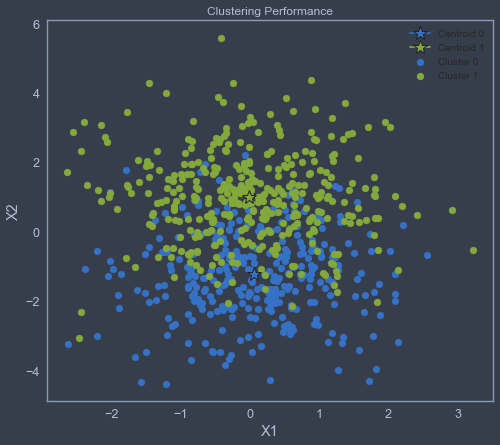

In [4]:
model = KMeans(max_iter=1500, tolerance=0.001, n_clusters=2, runs=100)
(clusters, data_with_clusters) = model.fit(X)

scatter1(xl="X1", yl="X2", title="Clustering Performance")

In [5]:
gmm = GMM(k=2, max_iter=1000)
gmm.fit(X)

y = gmm.predict(X)

acc = 0.0
for i in range(0, len(y)):
    if y[i] == Y[i]:
        acc += 1
print(f"accuracy: {100*acc/len(y):5.2f}%")

accuracy: 22.86%


#### Part 2:

In a separated cell, implement `Purity` and `Rand-Index` criteria in order to compare the performance of mentioned algorithms.

In [6]:
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0]==i, 1]), 2).sum() for i in set(clusters))
    fp = tp_plus_fp-tp
    fn = tp_plus_fn-tp
    tn = comb(len(A), 2)-tp-fp-fn
    return (tp+tn)/(tp+fp+fn+tn)

print(f"rand index score: {rand_index_score(Y, y):5.3f}")

rand index score: 0.491


In [7]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0))/np.sum(contingency_matrix)

print(f"purity score: {purity_score(Y, y):5.3f}")

purity score: 0.481


#### Part 3:

Use the following cell in order to create new Datasets. Afterwards, try to execute mentioned algorithms on new Dataset and eventually compare the recent results with the help of visualization(there is no problem for using relevant python libraries like `matplotlib`). Consider two clusters for this part.

In [8]:
def scatter2(xl, yl, title):
    jtplot.style(theme="onedork", context="notebook", grid=False)
    plt.close()
    xx = []
    yy = []
    for i in range(0, len(X)):
        xx.append(X[i][0])
        yy.append(X[i][1])

    colormap = np.array(['r', 'g'])
    plt.scatter(xx, yy, c=colormap[np.array(y)])
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
#     plt.plot(cluster_mean[0], cluster_mean[1], label=f"Centroid {i}", marker='*', markersize=15, markeredgecolor='k', markeredgewidth=1)
#     plt.style.use("seaborn")
#     plt.legend()

In [9]:
X, Y = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0, n_classes=2)

model = KMeans(max_iter=500, tolerance=0.001, n_clusters=2, runs=100)
(clusters, data_with_clusters) = model.fit(X)

gmm = GMM(k=2, max_iter=1000)
gmm.fit(X)
y = gmm.predict(X)

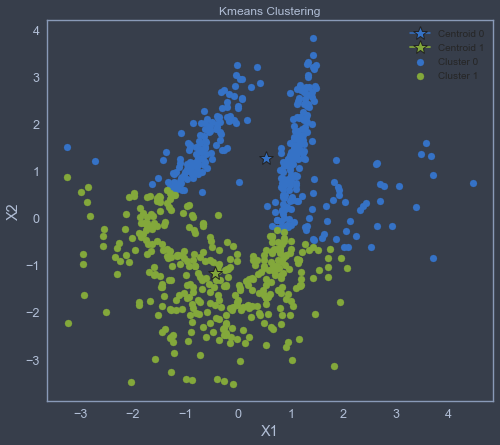

In [10]:
scatter1(xl="X1", yl="X2", title="Kmeans Clustering")

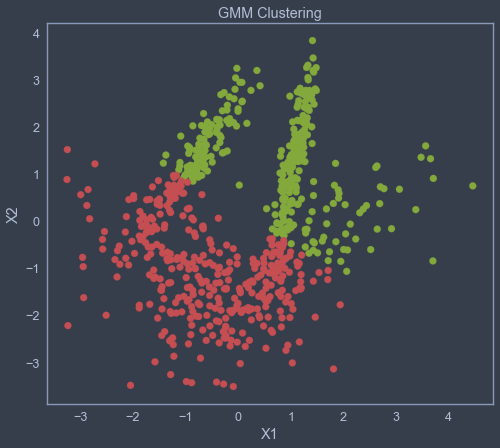

In [11]:
scatter2(xl="X1", yl="X2", title="GMM Clustering")

---

In [12]:
X, Y = make_moons(n_samples=700, noise=0.2)

model = KMeans(max_iter=500, tolerance=0.001, n_clusters=2, runs=100)
(clusters, data_with_clusters) = model.fit(X)

gmm = GMM(k=2, max_iter=1000)
gmm.fit(X)
y = gmm.predict(X)

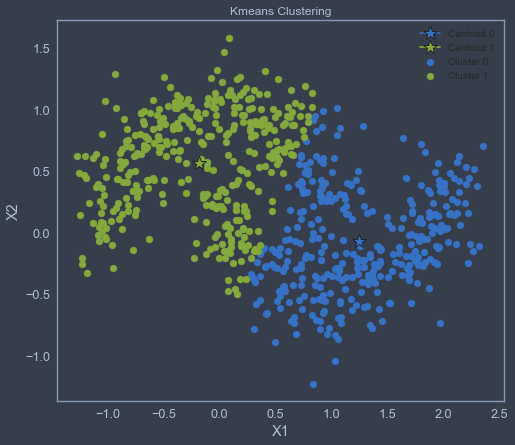

In [13]:
scatter1(xl="X1", yl="X2", title="Kmeans Clustering")

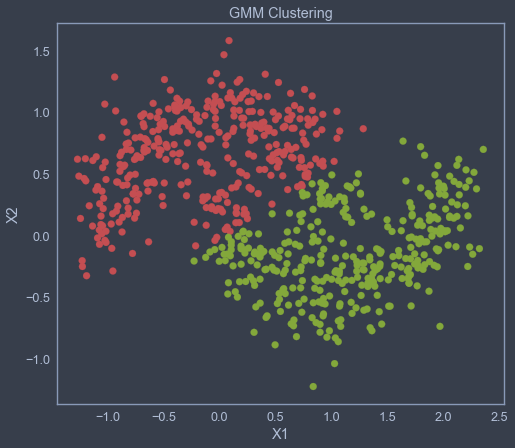

In [14]:
scatter2(xl="X1", yl="X2", title="GMM Clustering")

---

In [15]:
X, Y = make_circles(n_samples=700, noise=0.2)

model = KMeans(max_iter=500, tolerance=0.001, n_clusters=2, runs=100)
(clusters, data_with_clusters) = model.fit(X)

gmm = GMM(k=2, max_iter=1000)
gmm.fit(X)
y = gmm.predict(X)

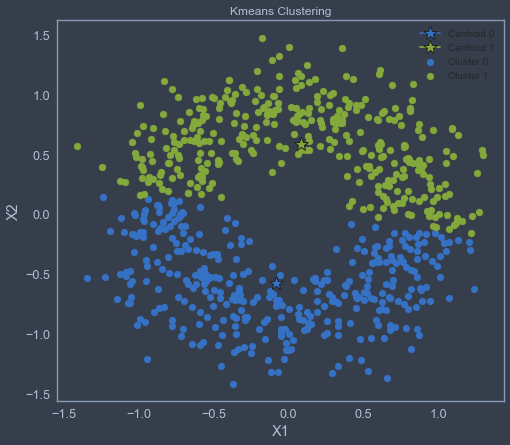

In [16]:
scatter1(xl="X1", yl="X2", title="Kmeans Clustering")

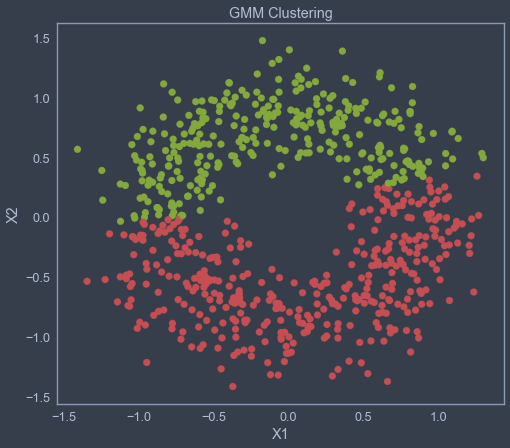

In [17]:
scatter2(xl="X1", yl="X2", title="GMM Clustering")

### Reinforcement Learning:

At the bellow cell, besides the required libraries have been imported, feel free for changing the num_states variable with your desired number.

In [18]:
env = gym.make("MountainCar-v0")
num_actions = 3
num_states = 900
q_table = np.zeros(shape=(num_states, num_actions))

#### Part 1:

Next cell wants you supplement two functions. First for transforming the continuous space into discrete one (in order to make using q_table feasible), second for updating q_values based on the last action done by agent.

In [19]:
# This is just one example of a discretization function. You can change it as you want.
def discretize_state(x, minn, step):
    return int((x-minn)/step)


def env_state_to_Q_state(state):
    [position, velocity] = state
    n_pos_states = 30
    n_vel_states = 30
    assert n_pos_states*n_vel_states==num_states
    a = discretize_state(position, -1.2, 1.8/n_pos_states)
    b = discretize_state(velocity, -0.07, 0.14/n_vel_states)
    if a == n_pos_states:
        a -= 1
    if b == n_vel_states:
        b -= 1
    return a*n_vel_states+b


def update_q(q_table, state, state1, state2, action, reward, done, discount, lr):
    if done and state[0] >= 0.5:
        q_table[state1, action] = reward
    else:
        q_table[state1, action] += lr*(reward+discount*np.max(q_table[state2, :])-q_table[state1, action])

#### Part 2:

At the following cell, the ends of two functions are getting current action based on the policy and defining the training process respectively.

In [20]:
# You may change the inputs of any function as you desire.
def get_action(state, epsilon):
    if np.random.random() < 1 - epsilon:
        action = np.argmax(q_table[state, :])
    else:
        action = np.random.randint(0, env.action_space.n)
    return action


def q_learning(env, lr, discount, epsilon, epsilon_decay, min_eps, episodes):
    for i in range(episodes):
        done = False
        state = env.reset()
        state1 = env_state_to_Q_state(state)
        while done != True:
            if i >= (episodes-5):
                epsilon = 0
                env.render()
            action = get_action(state1, epsilon)
            state, reward, done, _ = env.step(action)
            state2 = env_state_to_Q_state(state)
            update_q(q_table, state, state1, state2, action, reward, done, discount, lr)
            state1 = state2
            epsilon = max(epsilon-epsilon_decay, min_eps)
    env.close()


def save_policy(q_table):
    np.save("policy.npy", np.argmax(q_table, axis=1))

In [21]:
q_table = np.zeros(shape=(num_states, num_actions))
q_learning(env, 0.1, 1, 1.0, 0.001, 0.01, 10000)
save_policy(q_table)

#### Part 3:

Ultimately, the score function examines the average performance of Agent (after nearly 1000 times) based on previous implementations.

In [22]:
# Attention: don't change this function. we will use this to grade your policy which you will hand in with policy.npy
# btw you can use it to see how you are performing. Uncomment two lines which are commented to be able to see what is happening visually.
def score():
    policy, scores = np.load("policy.npy"), []
    for episode in range(1000):
        print(f"******Episode {episode}")
        state, score, done, step = env_state_to_Q_state(env.reset()), 0, False, 0
        while not done:
            # time.sleep(0.04)
            action = policy[state]
            state, reward, done, _ = env.step(action)
            state = env_state_to_Q_state(state)
            step += 1
            score += int(reward)
            # env.render()
        print(f"Score: {score}")
        scores.append(score)
    print(f"Average score over 1000 run: {np.array(scores).mean()}")

score()

******Episode 0
Score: -185
******Episode 1
Score: -190
******Episode 2
Score: -187
******Episode 3
Score: -181
******Episode 4
Score: -158
******Episode 5
Score: -144
******Episode 6
Score: -200
******Episode 7
Score: -148
******Episode 8
Score: -145
******Episode 9
Score: -188
******Episode 10
Score: -192
******Episode 11
Score: -163
******Episode 12
Score: -144
******Episode 13
Score: -144
******Episode 14
Score: -144
******Episode 15
Score: -188
******Episode 16
Score: -190
******Episode 17
Score: -181
******Episode 18
Score: -158
******Episode 19
Score: -143
******Episode 20
Score: -183
******Episode 21
Score: -143
******Episode 22
Score: -200
******Episode 23
Score: -144
******Episode 24
Score: -193
******Episode 25
Score: -193
******Episode 26
Score: -200
******Episode 27
Score: -144
******Episode 28
Score: -145
******Episode 29
Score: -146
******Episode 30
Score: -185
******Episode 31
Score: -145
******Episode 32
Score: -144
******Episode 33
Score: -192
******Episode 34
Score: 

Score: -144
******Episode 293
Score: -146
******Episode 294
Score: -144
******Episode 295
Score: -144
******Episode 296
Score: -192
******Episode 297
Score: -144
******Episode 298
Score: -146
******Episode 299
Score: -147
******Episode 300
Score: -184
******Episode 301
Score: -155
******Episode 302
Score: -167
******Episode 303
Score: -161
******Episode 304
Score: -162
******Episode 305
Score: -158
******Episode 306
Score: -144
******Episode 307
Score: -144
******Episode 308
Score: -181
******Episode 309
Score: -200
******Episode 310
Score: -144
******Episode 311
Score: -144
******Episode 312
Score: -144
******Episode 313
Score: -200
******Episode 314
Score: -143
******Episode 315
Score: -144
******Episode 316
Score: -145
******Episode 317
Score: -145
******Episode 318
Score: -188
******Episode 319
Score: -147
******Episode 320
Score: -144
******Episode 321
Score: -143
******Episode 322
Score: -193
******Episode 323
Score: -193
******Episode 324
Score: -143
******Episode 325
Score: -20

Score: -195
******Episode 574
Score: -194
******Episode 575
Score: -146
******Episode 576
Score: -146
******Episode 577
Score: -182
******Episode 578
Score: -200
******Episode 579
Score: -149
******Episode 580
Score: -194
******Episode 581
Score: -144
******Episode 582
Score: -155
******Episode 583
Score: -200
******Episode 584
Score: -200
******Episode 585
Score: -181
******Episode 586
Score: -145
******Episode 587
Score: -155
******Episode 588
Score: -192
******Episode 589
Score: -146
******Episode 590
Score: -144
******Episode 591
Score: -146
******Episode 592
Score: -200
******Episode 593
Score: -148
******Episode 594
Score: -200
******Episode 595
Score: -148
******Episode 596
Score: -148
******Episode 597
Score: -146
******Episode 598
Score: -146
******Episode 599
Score: -144
******Episode 600
Score: -149
******Episode 601
Score: -144
******Episode 602
Score: -186
******Episode 603
Score: -144
******Episode 604
Score: -144
******Episode 605
Score: -200
******Episode 606
Score: -14

Score: -146
******Episode 867
Score: -145
******Episode 868
Score: -143
******Episode 869
Score: -144
******Episode 870
Score: -159
******Episode 871
Score: -145
******Episode 872
Score: -165
******Episode 873
Score: -144
******Episode 874
Score: -144
******Episode 875
Score: -200
******Episode 876
Score: -145
******Episode 877
Score: -144
******Episode 878
Score: -194
******Episode 879
Score: -194
******Episode 880
Score: -183
******Episode 881
Score: -184
******Episode 882
Score: -144
******Episode 883
Score: -184
******Episode 884
Score: -192
******Episode 885
Score: -147
******Episode 886
Score: -143
******Episode 887
Score: -146
******Episode 888
Score: -148
******Episode 889
Score: -200
******Episode 890
Score: -200
******Episode 891
Score: -159
******Episode 892
Score: -147
******Episode 893
Score: -144
******Episode 894
Score: -144
******Episode 895
Score: -195
******Episode 896
Score: -185
******Episode 897
Score: -144
******Episode 898
Score: -142
******Episode 899
Score: -14